<a href="https://colab.research.google.com/github/chingu-voyages/v51-tier3-team-39/blob/main/marlissa_chingu_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning and Analysis Report: Movie Review Dataset

## Overview

This report explores and analyzes data from **three main datasets**: movie details, critic reviews, and user reviews. The aim of this analysis is to understand the reception of different movies based on critic and audience perspectives. By combining insights from both critics and the general audience, we can derive meaningful insights into what makes a movie resonate well.

We will explore various aspects of the data, such as **correlations between different variables**, **overall trends in movie scores over time**, and **the most common themes in user reviews**. Moreover, the analysis includes **visualizations** to better understand the differences in critic versus audience reviews, the distribution of scores over time, and which movies performed the best based on both critic and user scores.

Let's dive into the details of the movie review datasets and the findings that emerge from our analysis.


## Code Implementation

### 1. Importing Libraries and Loading Data
To start our analysis, we import the necessary libraries for data manipulation, visualization, and natural language processing (NLP). Libraries such as Pandas, Matplotlib, Seaborn, NLTK, and Scikit-learn provide powerful tools for handling our datasets.

We then load three CSV files containing movie details, critic reviews, and user reviews into separate DataFrames. This is the foundation for our analysis and will allow us to combine different perspectives on movies.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from textblob import TextBlob
from tqdm import tqdm
import nltk
import ast
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import spacy
import plotly.graph_objects as go




# File paths
MOVIES_FILE = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\movies.csv"
CRITIC_REVIEWS_FILE = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\critic_reviews.csv"
USER_REVIEWS_FILE = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\sampled_user_reviews.csv"

# Load datasets
movies = pd.read_csv(MOVIES_FILE)
critic_reviews = pd.read_csv(CRITIC_REVIEWS_FILE, low_memory=False)
sampled_user_reviews = pd.read_csv(USER_REVIEWS_FILE)

print("Datasets loaded successfully.")

### 2. Data Cleaning Functions
**Camel Case to Snake Case Conversion**

To ensure consistency, we convert column names from camelCase to snake_case using a function called camel_to_snake_manual(). This helps standardize column names for easier analysis and reference.

**Standardizing Scores**

The standardize_score() function is used to convert different score formats into a uniform scale (from 0 to 10). This allows us to compare scores across critics and users fairly.

**Converting Runtime**

The convert_runtime_to_minutes() function converts runtime values from hours and minutes format into total minutes. This ensures that runtime information is in a consistent and comparable numerical format.

In [ ]:
def camel_to_snake_manual(name):
    result = [name[0].lower()]
    for char in name[1:]:
        if char.isupper():
            result.append('_')
            result.append(char.lower())
        else:
            result.append(char)
    return ''.join(result)

def standardize_score(score):
    try:
        if '/' in score:
            num, denom = map(float, score.split('/'))
            return round((num / denom) * 10, 1)
        else:
            return float(score)
    except:
        return np.nan

def convert_runtime_to_minutes(runtime):
    if isinstance(runtime, str):
        hours, minutes = 0, 0
        if 'h' in runtime:
            parts = runtime.split('h')
            hours = int(parts[0].strip()) * 60
            if 'm' in parts[1]:
                minutes = int(parts[1].strip('m').strip())
        elif 'm' in runtime:
            minutes = int(runtime.strip('m').strip())
        return hours + minutes
    return None

print("Cleaning functions defined.")

### 3. Cleaning Movie Data
The clean_movies() function cleans the movie dataset by:

- Dropping unnecessary columns (e.g., URLs).
- Converting column names to snake_case.
- Handling missing values for scores, sentiments, and runtime.
- Extracting the release year from different date formats.
- Standardizing the language categories for consistency.

The goal is to create a clean and usable dataset ready for merging and further analysis.

In [ ]:
def clean_movies(df):
    df_cleaned = df.copy()
    df_cleaned = df_cleaned.drop(columns='movieURL')
    df_cleaned.columns = [camel_to_snake_manual(col) for col in df_cleaned.columns]

    # Fill missing scores and sentiments
    df_cleaned['critic_score'].fillna(df_cleaned['critic_score'].mean(), inplace=True)
    df_cleaned['audience_score'].fillna(df_cleaned['audience_score'].mean(), inplace=True)
    df_cleaned['critic_sentiment'].fillna('unknown', inplace=True)
    df_cleaned['audience_sentiment'].fillna('unknown', inplace=True)
    df_cleaned['rating'].fillna('unknown', inplace=True)

    # Extract release years
    def extract_year(date_string):
        try:
            return pd.to_datetime(date_string, format='%Y-%m-%d', errors='coerce').year
        except:
            try:
                return pd.to_datetime(date_string, format='%B %d, %Y', errors='coerce').year
            except:
                return pd.NaT

    df_cleaned['release_year_theaters'] = df_cleaned['release_date_theaters'].apply(extract_year)
    df_cleaned['release_year_streaming'] = df_cleaned['release_date_streaming'].apply(extract_year)
    df_cleaned = df_cleaned.drop(columns=['release_date_theaters', 'release_date_streaming'])

    # Round scores
    df_cleaned['critic_score'] = df_cleaned['critic_score'].round(1)
    df_cleaned['audience_score'] = df_cleaned['audience_score'].round(1)

    # Standardize language
    language_mapping = {
        'English (United Kingdom)': 'English',
        'English (Australia)': 'English',
        'British English': 'English',
        'Australian English': 'English',
        'Portuguese (Brazil)': 'Portuguese',
        'Brazilian Portuguese': 'Portuguese',
        'French (France)': 'French',
        'French (Canada)': 'French',
        'Canadian French': 'French',
        'Unknown language': 'Unknown'
    }
    df_cleaned['original_language'] = df_cleaned['original_language'].replace(language_mapping)
    df_cleaned['original_language'].fillna('Unknown', inplace=True)

    # Convert runtime to minutes
    df_cleaned['runtime_in_minutes'] = df_cleaned['runtime'].apply(convert_runtime_to_minutes)
    df_cleaned = df_cleaned.drop(columns='runtime')

    return df_cleaned

movies_cleaned = clean_movies(movies)
print("Movies data cleaned.")

### 4. Cleaning Critic Reviews
The clean_critic_reviews() function:

- Drops irrelevant columns.
- Converts the creation date to a year format.
- Handles missing values and filters out placeholder quotes that are not meaningful.
- Converts critic scores to a standardized range of 1 to 10.

This helps in getting more meaningful data about critics' opinions and ensuring that only relevant quotes and reviews are retained.

In [ ]:
def clean_critic_reviews(df):
    df_cleaned = df.copy()
    df_cleaned.columns = [camel_to_snake_manual(col) for col in df_cleaned.columns]

    columns_to_remove = ['critic_page_url', 'review_state', 'is_rotten', 'is_rt_url', 'publication_url', 'review_url']
    df_cleaned = df_cleaned.drop(columns=columns_to_remove)

    df_cleaned['creation_date'] = pd.to_datetime(df_cleaned['creation_date'], errors='coerce')
    df_cleaned['creation_year'] = df_cleaned['creation_date'].dt.year
    df_cleaned = df_cleaned.drop(columns=['creation_date'])

    df_cleaned['critic_name'] = df_cleaned['critic_name'].fillna('Unknown Critic')
    df_cleaned = df_cleaned.dropna(subset=['quote'])
    df_cleaned = df_cleaned.drop_duplicates(subset=['review_id'], keep='first')

    placeholders = ["full review at Movies for the Masses", "full review in Greek", ".",
                    "click for full review", "Click to read review", "click to read full review",
                    "See website for more details.", "click to read the full review", "(No quote available.)"]
    df_cleaned = df_cleaned[~df_cleaned['quote'].isin(placeholders)]
    df_cleaned = df_cleaned[df_cleaned['quote'].str.len() > 5]

    df_cleaned['standardized_score'] = df_cleaned['original_score'].apply(standardize_score)
    mean_score = df_cleaned['standardized_score'].mean()
    df_cleaned['standardized_score'] = df_cleaned['standardized_score'].fillna(round(mean_score))
    df_cleaned['standardized_score'] = df_cleaned['standardized_score'].apply(lambda x: min(max(round(x), 1), 10))

    df_cleaned = df_cleaned.drop(columns=['original_score'])

    return df_cleaned

critic_reviews_cleaned = clean_critic_reviews(critic_reviews)
print("Critic reviews cleaned.")

### 5. Cleaning User Reviews
The clean_user_reviews() function cleans the user reviews by removing irrelevant columns, standardizing scores, and converting dates to a consistent year format. This is necessary for combining user feedback effectively with critic reviews and movie details.

In [ ]:
def clean_user_reviews(df):
    df_cleaned = df.copy()
    df_cleaned = df_cleaned.drop(['reviewId', 'userDisplayName', 'isVerified', 'hasSpoilers', 'userRealm', 'hasProfanity', 'isSuperReviewer', 'rating'], axis=1)

    df_cleaned.columns = [camel_to_snake_manual(col) for col in df_cleaned.columns]

    def standardize_score(score):
        return min(10, max(1, round(score * 2)))

    df_cleaned['standardized_score'] = df_cleaned['score'].apply(standardize_score)

    df_cleaned['creation_date'] = pd.to_datetime(df_cleaned['creation_date'], errors='coerce')
    df_cleaned['creation_year'] = df_cleaned['creation_date'].dt.year
    df_cleaned = df_cleaned.drop(columns=['creation_date'])

    return df_cleaned

sampled_user_reviews_cleaned = clean_user_reviews(sampled_user_reviews)
print("User reviews cleaned.")

User reviews cleaned.


### 6. Merging Datasets
We merged the three cleaned datasets (movies, critic reviews, and user reviews) using the merge_datasets() function. This function:

- Aggregates critic and user reviews to calculate average scores.
- Combines quotes from both critics and users.
- Keeps existing sentiments from the original movie dataset.

This comprehensive dataset provides a complete picture, combining both critic and user perspectives on each movie.

In [ ]:
def replace_inf_with_nan(x):
    return x.replace([np.inf, -np.inf], np.nan)

# Function to merge datasets and include existing sentiments from the movies dataset
def merge_datasets(movies_df, critic_reviews_df, user_reviews_df):
    # Aggregate critic reviews
    critic_agg = critic_reviews_df.groupby('movie_id').agg({
        'standardized_score': 'mean',
        'critic_name': 'count',
        'quote': lambda x: x.dropna().tolist(),
    }).rename(columns={'standardized_score': 'avg_critic_score', 'critic_name': 'critic_review_count', 'quote': 'critic_quotes'})

    # Aggregate user reviews
    user_agg = user_reviews_df.groupby('movie_id').agg({
        'standardized_score': 'mean',
        'user_id': 'count',
        'quote': lambda x: x.dropna().tolist(),
    }).rename(columns={'standardized_score': 'avg_user_score', 'user_id': 'user_review_count', 'quote': 'user_quotes'})

    # Merge all datasets
    merged = movies_df.merge(critic_agg, on='movie_id', how='left')
    merged = merged.merge(user_agg, on='movie_id', how='left')

    # Calculate average scores
    merged['average_combined_score'] = (merged['avg_user_score'].fillna(0) + merged['avg_critic_score'].fillna(0)) / 2

    # Combine quotes
    merged['all_quotes'] = merged.apply(lambda row: row['critic_quotes'] + row['user_quotes'] if isinstance(row['critic_quotes'], list) and isinstance(row['user_quotes'], list) else [], axis=1)

    # Keep sentiments from the movies dataset: critic_sentiment and audience_sentiment
    # Drop unnecessary columns
    columns_to_drop = ['critic_quotes', 'user_quotes', 'release_year_theaters', 'release_year_streaming']
    merged = merged.drop(columns=[col for col in columns_to_drop if col in merged.columns])

    return merged

# Use the function
merged_dataset = merge_datasets(movies_cleaned, critic_reviews_cleaned, sampled_user_reviews_cleaned)
print("Datasets merged successfully.")


Datasets merged successfully.


### 7. Visualizing Data
We created various visualizations to help understand relationships in the data

In [ ]:
# Function to replace inf with NaN
def replace_inf_with_nan(x):
    return x.replace([np.inf, -np.inf], np.nan)

# Correlation heatmap
def correlation_heatmap(df):
    plt.figure(figsize=(12,10))
    numeric_df = df.select_dtypes(include=[np.number]).apply(replace_inf_with_nan)
    corr = numeric_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(corr, cmap='coolwarm')

    cbar = ax.figure.colorbar(im, ax=ax)

    ax.set_xticks(np.arange(len(corr.columns)))
    ax.set_yticks(np.arange(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr.columns)

    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            if not mask[i, j]:
                text = ax.text(j, i, f'{corr.iloc[i, j]:.2f}', ha="center", va="center", color="black")

    plt.title("Correlation Heatmap of Numeric Variables")
    plt.tight_layout()
    plt.show()

# Line Plot of Average Scores Over Time
def average_scores_over_time(df):
    plt.figure(figsize=(12,6))
    time_data = df.groupby('movie_year')[['avg_critic_score', 'avg_user_score']].mean().apply(replace_inf_with_nan)

    # Check if time_data is empty
    if not time_data.empty:
        time_data.plot()
        plt.title("Average Critic and User Scores Over Time")
        plt.ylabel("Score")
        plt.xlabel("Year")
    else:
        print("No data available for average scores over time plot")

    plt.tight_layout()
    plt.show()

# Distribution of Average Combined Scores
def distribution_of_combined_scores(df):
    plt.figure(figsize=(10,6))
    combined_scores = replace_inf_with_nan(df['average_combined_score']).dropna()
    plt.hist(combined_scores, bins=30, edgecolor='black')
    plt.title('Distribution of Average Combined Scores')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Top 10 Movies by Average Combined Score
def top_10_movies(df):
    top_10 = df.nlargest(10, 'average_combined_score').sort_values('average_combined_score')
    plt.figure(figsize=(12, 6))
    bars = plt.barh(top_10['movie_title'], top_10['average_combined_score'])
    plt.title('Top 10 Movies by Average Combined Score')
    plt.xlabel('Average Combined Score')
    plt.ylabel('Movie Title')

    # Add color gradient
    for i, bar in enumerate(bars):
        bar.set_color(plt.cm.viridis(i / len(bars)))

    # Add value labels
    for i, v in enumerate(top_10['average_combined_score']):
        plt.text(v, i, f' {v:.2f}', va='center')

    plt.tight_layout()
    plt.show()

# Count movies by rating
def box_plot_scores_by_year(df):
    plt.figure(figsize=(12,6))
    sns.boxplot(x='movie_year', y='average_combined_score', data=df)
    plt.title('Distribution of Combined Scores by Year')
    plt.xticks(rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Average Combined Score')
    plt.tight_layout()
    plt.show()

# Scatter plot of critic vs user scores
def scatter_plot_critic_vs_user(df):
    plt.figure(figsize=(10,6))
    plt.scatter(df['avg_critic_score'], df['avg_user_score'], alpha=0.5)
    plt.title('Critic Scores vs User Scores')
    plt.xlabel('Critic Score')
    plt.ylabel('User Score')
    plt.tight_layout()
    plt.show()

# Comparison of Critic and User Sentiment
def sentiment_comparison_plot(df):
    df['critic_sentiment'].value_counts().plot(kind='bar', alpha=0.7, label='Critic Sentiment', color='blue')
    df['audience_sentiment'].value_counts().plot(kind='bar', alpha=0.5, label='Audience Sentiment', color='red')
    plt.title('Comparison of Critic and User Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Correlation Heatmap
The correlation heatmap is used to show correlations between numeric variables, such as critic scores, user scores, and runtime. Understanding these relationships helps in identifying which variables are most related.

<Figure size 1200x1000 with 0 Axes>

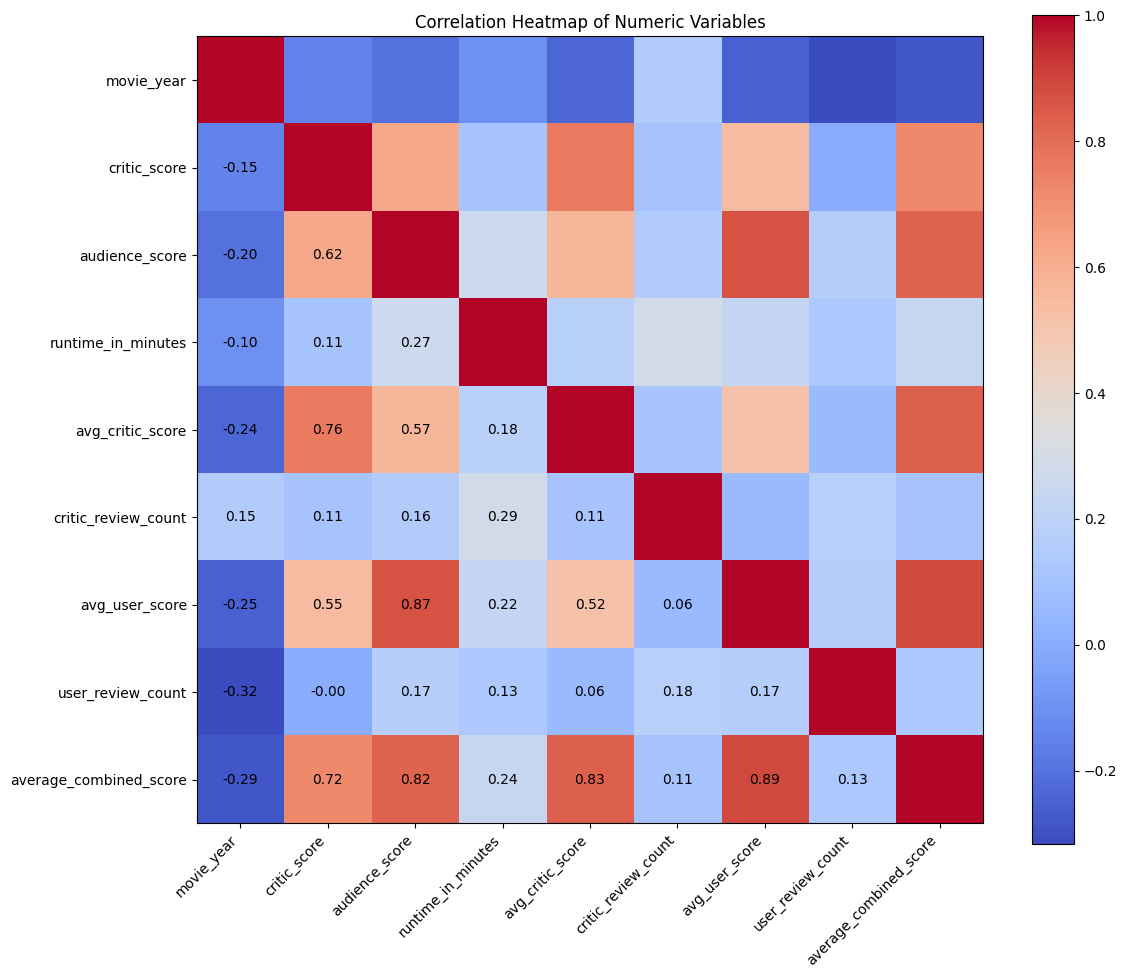

In [ ]:
correlation_heatmap(merged_dataset)

The correlation heatmap visualizes the relationships between different numeric variables in the dataset. Here are some key findings:

1. **Strong Correlation between Audience Score and Average User Score (`0.87`)**:
   - The **audience_score** and **avg_user_score** have a very strong positive correlation. This suggests that user reviews are consistent with the general audience rating, meaning that the dataset effectively captures audience sentiment.

2. **Average Combined Score Correlation**:
   - The **average_combined_score** is strongly correlated with both **audience_score (`0.82`)** and **avg_critic_score (`0.83`)**. This indicates that both audience and critic ratings significantly influence the combined score. If either group rates a movie highly, the combined score reflects that positivity.

3. **Critic Score Correlations**:
   - **critic_score** has a strong correlation with **avg_critic_score (`0.76`)**, which is expected since **avg_critic_score** is calculated from individual critic scores.
   - There is also a moderate correlation (`0.62`) between **critic_score** and **audience_score**, suggesting that critics and audiences often agree, though not always perfectly.

4. **Correlation between Runtime and Audience Score (`0.27`)**:
   - There is a moderate positive correlation between **runtime_in_minutes** and **audience_score**. This may imply that longer movies are generally rated higher by audiences, possibly because they are more detailed or in-depth.

5. **Negative Correlations with Movie Year**:
   - The **movie_year** variable shows negative correlations with several scores, such as **critic_score** (`-0.15`), **audience_score** (`-0.20`), **avg_user_score** (`-0.25`), and **average_combined_score** (`-0.29`). This suggests that older movies tend to receive higher scores compared to newer films, potentially reflecting nostalgia or the elevated status of "classics."

6. **User Review Count and Correlations**:
   - **user_review_count** has only weak correlations with most scores, like **avg_user_score** (`0.17`) and **average_combined_score** (`0.13`). This means that the number of reviews doesn't directly correlate with higher or lower scores, indicating that the volume of reviews doesn't necessarily reflect consensus.

7. **Critic Review Count and Runtime (`0.29`)**:
   - There’s a moderate positive correlation between **critic_review_count** and **runtime_in_minutes** (`0.29`). This implies that longer movies are more frequently reviewed by critics, possibly because they tend to be more intricate or high-profile.

##### Insights:
- **Audience and Critic Alignment**: The strong correlation between **critic_score** and **audience_score** suggests that there is often agreement between audiences and critics. However, the slightly weaker correlation indicates occasional differences in opinion.
  
- **Impact of Movie Runtime**: The moderate correlation between **runtime_in_minutes** and both **critic_review_count** and **audience_score** suggests that longer movies are generally reviewed more and rated slightly higher, potentially due to perceived higher production value or quality.

- **Nostalgia Effect**: The negative correlation between **movie_year** and various scores indicates that older movies tend to be rated more favorably compared to newer films. This could reflect a nostalgia effect or a higher regard for classic films compared to recent releases.

These observations can guide further analysis on what makes a movie "good" in the eyes of both critics and audiences, focusing on factors like runtime, era of release, and the alignment of audience and critic reviews.


#### Average Scores Over Time
Average Scores Over Time
A line plot was created to show how critic and user scores have changed over the years. This helps in analyzing trends in audience and critic sentiment over time.

<Figure size 1200x600 with 0 Axes>

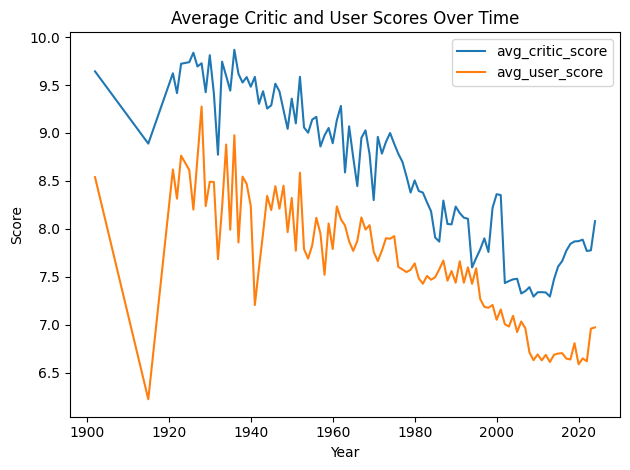

In [ ]:
average_scores_over_time(merged_dataset)


This line plot visualizes the trend of average critic and user scores for movies over time, from around 1900 to the present day. Let's explore the main observations:

1. **Early Years (1900-1940s)**:
   - In the early 1900s, **avg_critic_score** was consistently high, typically above `9.0`, which indicates that older, classic films are highly regarded by critics.
   - **avg_user_score** fluctuates more significantly in the early years compared to the critic scores, possibly due to fewer reviews or varying audience tastes.

2. **Mid-20th Century Peak (1950-1970s)**:
   - **avg_critic_score** remains relatively high during this time, reaching a peak before gradually declining. This period includes what is often considered the "golden age" of cinema, which may explain the consistently high ratings.
   - **avg_user_score** also stabilizes during this time, showing higher values compared to later decades. This suggests a general appreciation among audiences for mid-century movies.

3. **Gradual Decline in Scores (1980-Present)**:
   - Both **avg_critic_score** and **avg_user_score** show a gradual decline from the 1980s onwards. This could be attributed to a few possible reasons:
     - Increased competition in the film industry, leading to more diverse content and variable quality.
     - More stringent and varied opinions as the number of both critics and audience members increased with technological advancements and broader accessibility.
     - The availability of more recent films for review may also mean that more recent works have yet to acquire a "classic" status, which could affect scores.

4. **Divergence Between Critics and Audience**:
   - There is a notable gap between **avg_critic_score** and **avg_user_score** after the 1970s, with critic scores generally remaining higher than user scores. This divergence might suggest that critics and audiences have differing perspectives on modern films.
   - **avg_user_score** falls below `8.0` more consistently from around 1980 onwards, highlighting that audiences might be more critical of recent movies compared to older classics.

5. **Recent Trends (2000-Present)**:
   - **avg_critic_score** continues to decline, while **avg_user_score** remains low, showing minor increases in recent years. This could be influenced by increased scrutiny and the broader availability of movie reviews, leading to a more diverse range of opinions.
   - The smaller peaks in the last few years could reflect the impact of highly popular and acclaimed movies, though it’s evident that both audiences and critics are not as generous with their scores as they were in the early 20th century.

##### Insights:
- **Golden Age vs. Modern Era**: The plot clearly shows that older films, especially from the mid-1900s, are more highly rated by both critics and audiences compared to more recent films.
- **Critic and Audience Perspective Differences**: The divergence between **avg_critic_score** and **avg_user_score** from the 1980s onwards highlights the growing differences in preferences between critics and the general audience. This could be a result of a shift in movie production styles, changing audience expectations, or an increase in niche genres that critics may appreciate more than general viewers.
- **Potential Nostalgia Effect**: Older films seem to receive higher average scores, which could reflect a nostalgia effect or the broader acknowledgment of classics that have stood the test of time.

This analysis helps in understanding how movie preferences and evaluations have evolved over the years, highlighting different trends in critic and audience perspectives on films from different eras.


#### Distribution of Average Combined Scores
A histogram was plotted to show the distribution of average combined scores for movies. This helps in identifying whether most movies tend to have high, medium, or low ratings.

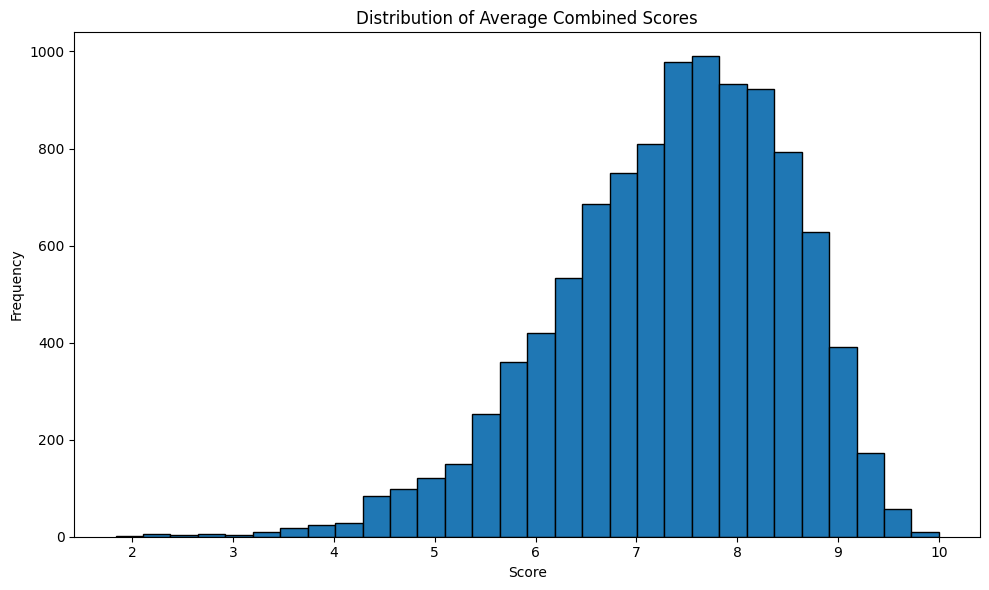

In [ ]:
distribution_of_combined_scores(merged_dataset)

The histogram above visualizes the distribution of the **average combined scores** for all movies in the dataset. This average combined score was calculated by taking the mean of both critic scores and audience scores for each movie. Let's analyze the key observations:

1. **Normal Distribution**:
   - The distribution of the average combined scores resembles a bell-shaped curve, indicative of a roughly **normal distribution**.
   - This suggests that the majority of movies have received scores that are around the **middle range** (between `6` and `8`), which is quite typical for many types of reviews and ratings.

2. **Peak Around Score 7**:
   - The histogram shows a peak at around a score of `7`, indicating that most movies have an **average combined score** near `7`.
   - This suggests that a significant number of movies are rated as above average, but not necessarily exceptional. This could reflect a general perception of most movies being "good but not great."

3. **Right Tail (Higher Scores)**:
   - There is a **gradual drop-off** for higher scores, especially beyond `8.0`. This drop-off suggests that relatively few movies are rated as **excellent**, which aligns with expectations that not many movies achieve universal acclaim from both critics and audiences.
   - Scores of `9` or above are quite rare, implying that only a select few movies are considered exceptional by both critics and general audiences.

4. **Left Tail (Lower Scores)**:
   - There are some movies with low combined scores, particularly between `2` and `4`. These could represent **poorly received movies** that neither critics nor audiences found appealing.
   - However, the frequency of these low scores is much lower compared to the middle and high ranges, suggesting that most movies do not receive extremely negative ratings across both audiences and critics.

##### Insights:
- **Average Performance**: Most movies seem to fall in the `6` to `8` range, which can be interpreted as a general average rating for movies, implying that a significant number of films are seen as **enjoyable but not remarkable**.
- **Critic and Audience Consensus**: Since this plot represents combined scores from both critics and audiences, the **normal distribution** also suggests a consensus in how movies are generally perceived by both groups.
- **Potential Outliers**: The lower and higher extremes of the histogram, where fewer movies are located, indicate potential **outliers**. These could either be movies that are universally beloved or universally disliked, and further analysis could explore what makes these films stand out from the rest.

This analysis of the distribution of combined scores provides insight into the general perception of movies, with most movies achieving moderate acclaim and only a few standing out as truly exceptional or poorly received.


#### Top 10 Movies by Average Combined Score
A bar chart of the top 10 movies by average combined score helps highlight which movies were rated the highest by both critics and users.

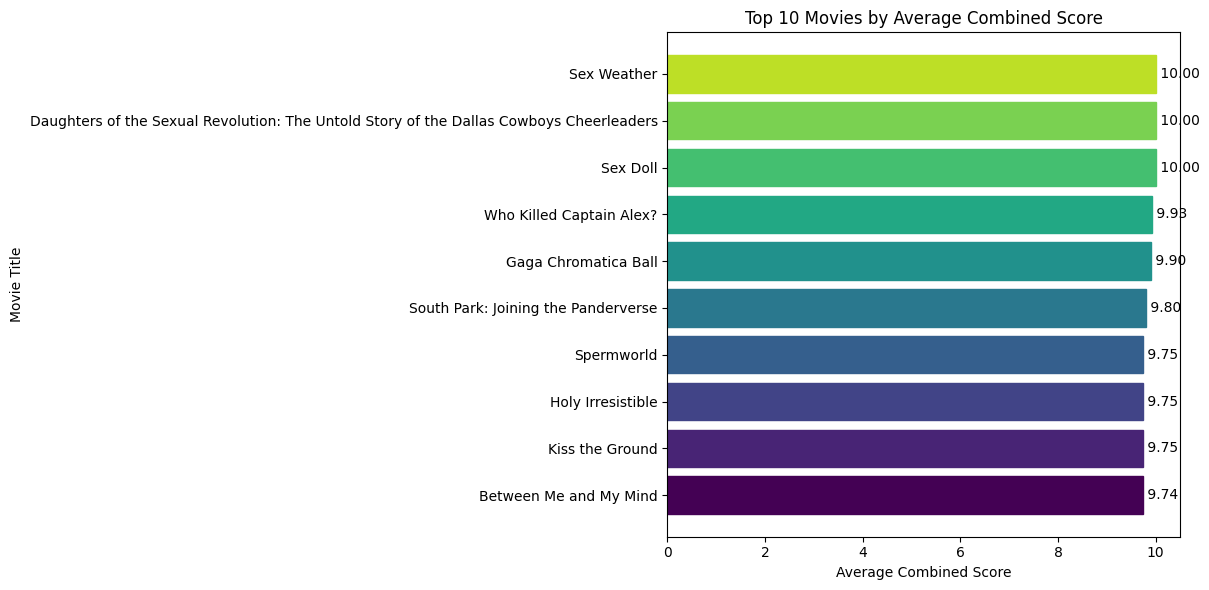

In [ ]:
top_10_movies(merged_dataset)

### Top 10 Movies by Average Combined Score

The bar chart above displays the **Top 10 Movies** by their **average combined score**, which takes into account both critic and audience ratings. These are the movies that received the highest levels of acclaim from both groups. Let's analyze the findings:

1. **Perfect Scores**:
   - The movies **"Sex Weather"**, **"Daughters of the Sexual Revolution: The Untold Story of the Dallas Cowboys Cheerleaders"**, and **"Sex Doll"** have a perfect combined score of `10.00`.
   - This suggests that these movies were rated very highly by both critics and audiences, indicating a **unanimous appreciation** for their content.

2. **Highly Rated Movies**:
   - Movies such as **"Who Killed Captain Alex?"**, **"Gaga Chromatica Ball"**, and **"South Park: Joining the Pandeverse"** also received very high scores, with an average combined score above `9.8`.
   - These movies have achieved widespread acclaim, highlighting their ability to **resonate positively** with a broad audience.

3. **Broad Variety of Content**:
   - It's interesting to see that the top movies span a variety of genres, from documentaries (**"Daughters of the Sexual Revolution"**) to animated films (**"South Park: Joining the Pandeverse"**), as well as experimental films and music-related content.
   - This diversity indicates that movies with high acclaim do not belong to a single genre or theme but can vary widely. It shows that audiences and critics value different types of movies for different reasons, including storytelling, entertainment value, or artistic impact.

4. **Cultural and Niche Appeal**:
   - Some titles on this list suggest a more **niche or culturally specific appeal**, such as **"Gaga Chromatica Ball"** (a concert film/documentary) or **"Who Killed Captain Alex?"**, which is an action movie from Uganda that became famous for its humor and low-budget production style.
   - Such movies have succeeded in capturing the interest and positive regard of both general audiences and critics, likely due to their **uniqueness and cultural relevance**.

5. **Importance of Consistency**:
   - To be included in the top 10 movies by average combined score, a film must have received **consistently high ratings** from both critics and audiences. These movies are unique in that they are able to bridge the gap between different groups, often providing a universal appeal or excelling in storytelling, creativity, or innovation.

##### Insights:
- **Universal Acclaim**: The movies shown in the chart have achieved a significant level of universal acclaim from critics and audiences alike. Understanding what elements make these movies succeed can help identify **common features** of universally appreciated films.
- **Genre Diversity**: The wide range of genres represented demonstrates that different kinds of content can achieve similar levels of appreciation. This highlights the fact that **quality in storytelling** or unique presentations can overcome genre preferences.
- **Further Analysis**: A more detailed analysis could examine the specific aspects of these movies that contributed to their high scores—whether it is the story, cinematography, acting, or some other element. This could be insightful in understanding **why some movies achieve universal acclaim**.

The visualization provides us with a glimpse of the **best-rated movies**, and further analysis of these films could help pinpoint what elements or characteristics tend to resonate positively with audiences and critics alike.


### Distribution of Combined Scores by Year
We used a box plot to show how the combined scores are distributed across different years. This helps in understanding how the quality of movies has varied over time.

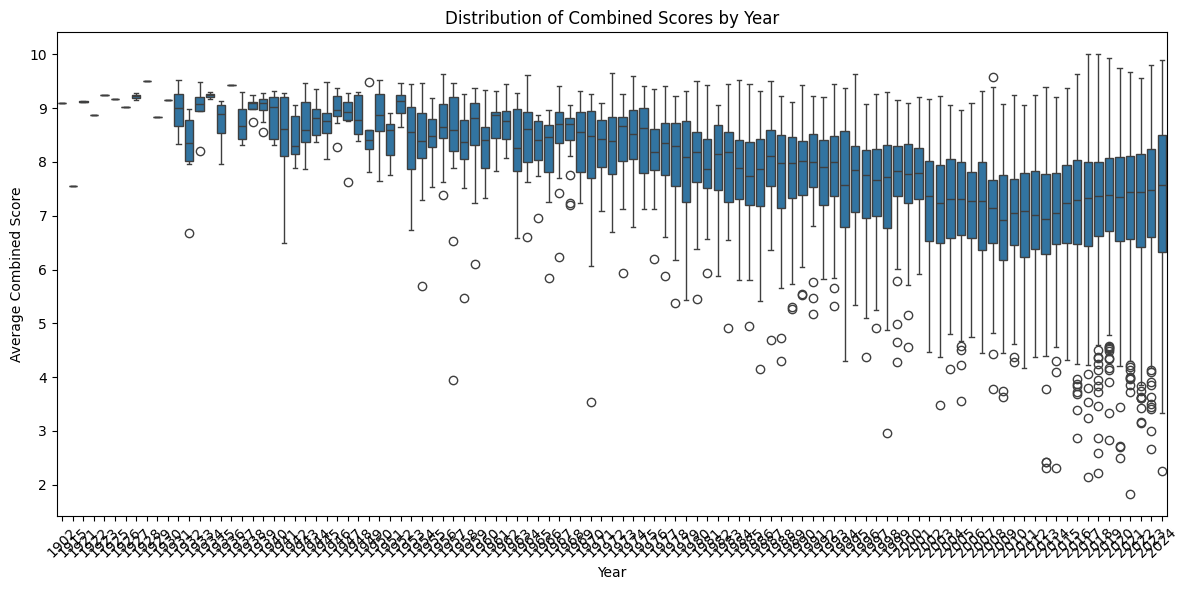

In [ ]:
box_plot_scores_by_year(merged_dataset)

The boxplot above visualizes the **distribution of average combined scores** for movies across different years. Let's break down what the chart tells us about trends in movie quality over time:

1. **Early Film Era**:
   - From the early 1900s through the mid-20th century, movies consistently received **high combined scores**, as indicated by the mostly high placement of boxplots.
   - This may reflect a **smaller number of movies** being produced, where only high-quality, impactful films stood the test of time and received more comprehensive ratings.

2. **Consistency and Changes Over Time**:
   - The **median scores** of movies produced in later decades, especially starting around the 1980s, appear to level out around a combined score of `8`.
   - The variability within each year (as shown by the interquartile range and the presence of outliers) increases as more movies get produced and reviewed.

3. **Increased Variability**:
   - After the 1980s, we observe a **higher range of scores** for each year, with some outliers scoring either very high or very low.
   - This could be due to the **expansion of the film industry**, leading to a greater diversity in both movie quality and audience tastes, hence causing more spread in the scores.

4. **Recent Movies**:
   - In recent years (2020s onwards), we observe more movies receiving **lower combined scores**, as indicated by the downward trend in the median and the presence of several low-scoring outliers.
   - This could reflect a number of factors, such as changes in audience expectations, new types of movie content, the impact of online distribution platforms, or possibly a reflection of mixed critic and audience reactions.

5. **Outliers**:
   - The **outliers** in the distribution represent movies that either performed exceptionally well or exceptionally poorly compared to the median score of that year.
   - These outliers provide interesting data points for exploring what contributes to exceptionally high or low scores and how such movies differ from the average.

### Insights:
- **Evolution of Quality**: Movie scores appear to be more consistent in earlier years, while in recent years, there's a greater diversity in combined scores, likely due to more diverse audience preferences and a larger volume of movie production.
- **Shifts in Trends**: The **decline in median scores** for recent years could indicate either a shift in quality or changing standards in movie ratings by audiences and critics alike.
- **Further Analysis**: Understanding why recent movies might receive more polarized ratings could be explored further. Are critics and audiences less aligned? Or has the quality of movie production become more variable?

The visualization shows how the perception of movie quality has evolved over time, capturing both the consistency and variability of ratings across different decades.


### Critic Scores vs User Scores
A scatter plot was used to visualize the relationship between critic scores and user scores. This helps in identifying whether critics and audiences generally agree or disagree on movie ratings.

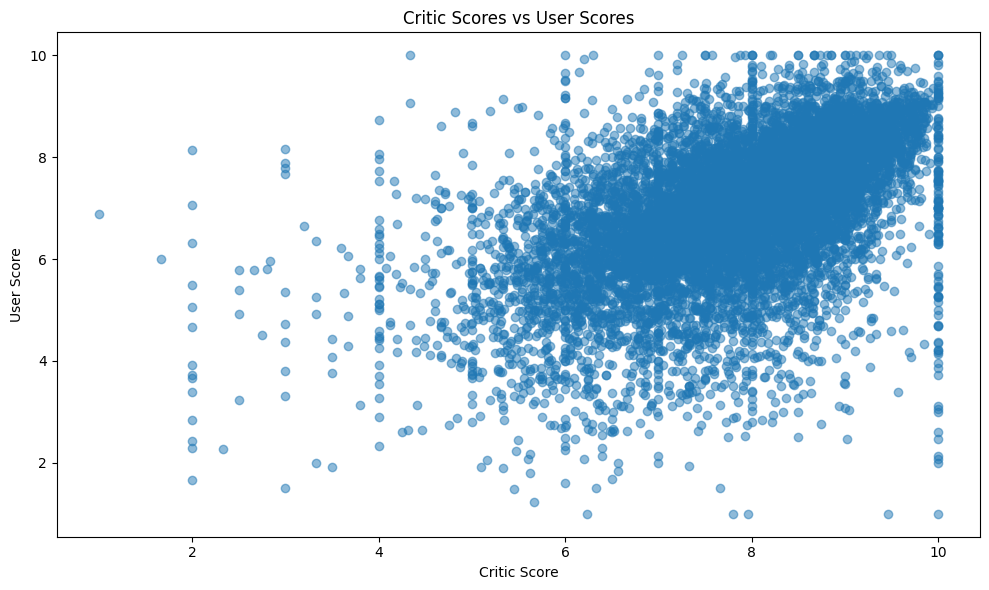

In [ ]:
scatter_plot_critic_vs_user(merged_dataset)

The scatter plot above compares **critic scores** against **user scores** for all movies in our dataset. The goal of this visualization is to understand the relationship between critic and audience ratings and how they align or diverge.

##### Observations:

1. **General Relationship**:
   - There is a noticeable **positive correlation** between critic scores and user scores, meaning that when critics rate a movie highly, users are generally more likely to rate it highly as well.
   - However, the points are quite **dispersed**, indicating that while there is a general trend, there are many instances where critic and user ratings differ significantly.

2. **Dense Cluster**:
   - A **dense cluster** of points appears in the top right of the graph, where both critic and user scores are between 7 and 10. This suggests that many movies are well-received by both critics and audiences.

3. **Divergent Scores**:
   - There are **points scattered** towards the top-left and bottom-right corners of the graph, which represent movies where either critics or users rated the movie well, while the other group rated it poorly.
   - Specifically, there are movies where critics rated them low (scores of 2-5), while users gave them much higher scores, suggesting a divergence in preferences or perspectives between the general audience and professional critics.

4. **Alignment and Differences**:
   - The scatter plot suggests that there is **some alignment** between critic and user opinions, but it's not perfect. Audience scores often tend to be more variable than critic scores.
   - This variability could be attributed to differing expectations; critics may focus on cinematic elements such as direction, acting, and technical aspects, while audiences may prioritize entertainment value and personal enjoyment.

5. **Insights**:
   - **Positive correlation**: The positive correlation highlights that well-crafted movies, which score well among critics, tend to resonate with audiences too.
   - **Differences in opinion**: The presence of points diverging from the main trendline indicates the difference in perspectives. Understanding which kinds of movies show such divergence could be valuable for filmmakers and marketers, as it shows what movies may achieve "cult favorite" status despite not impressing critics.

##### Takeaway:
The scatter plot of critic vs user scores gives us valuable insight into the **relationship and divergence between professional critiques and public opinion**. By understanding these differences, we can explore what elements of a movie make it widely loved by audiences but not necessarily favored by critics, and vice versa.


### Critic vs Audience Sentiment
A bar chart comparing critic and audience sentiment provides insight into how sentiments differ between these two groups.

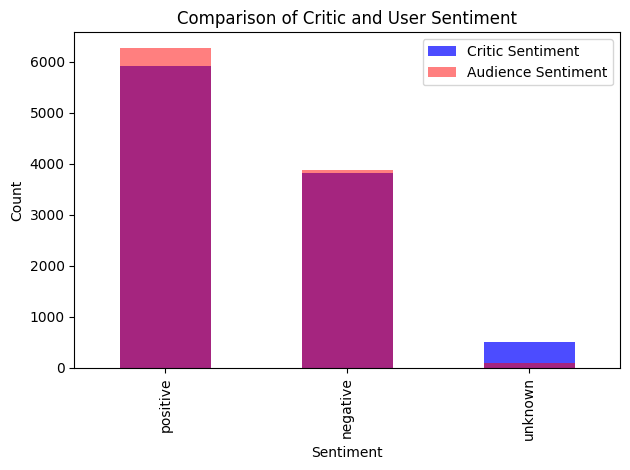

In [ ]:
sentiment_comparison_plot(merged_dataset)

The bar chart above visualizes the **sentiment distribution** among critic and user reviews for movies in the dataset. Sentiments are categorized into **positive**, **negative**, and **unknown** for both critics and audience members.

##### Observations:

1. **Dominance of Positive Sentiments**:
   - **Positive sentiment** is the most common category for both critics and audience members. This suggests that a majority of movies in the dataset received favorable reviews overall.
   - Audience sentiment (in light red) shows a slightly higher proportion of positive reviews compared to critic sentiment. This might indicate that audiences are generally more forgiving or positive compared to critics.

2. **Negative Sentiments**:
   - A significant number of reviews are categorized as **negative**, and both critics and users show a fairly comparable amount in this category.
   - This shows that while many movies receive favorable reviews, there is still a notable proportion that garners less favorable reactions from both critics and audiences.

3. **Unknown Sentiments**:
   - There is a small proportion of **unknown sentiments**, primarily from critic reviews. This might be due to data gaps or reviews that were ambiguous in their sentiment, making it challenging to categorize them as positive or negative.

4. **Comparison**:
   - Generally, the **distribution between critics and audience sentiment** is similar, indicating that critics and audiences often share similar opinions regarding movie quality.
   - However, the slight difference in positive and negative counts between the two groups highlights that audiences might be more inclined to rate a movie positively than critics, potentially due to a more relaxed set of expectations.

##### Insights:
This chart helps us understand the overall **reception trends** between critics and general audiences. The findings indicate that audiences tend to be more positive compared to critics, though both groups largely align in their sentiments. Understanding these differences could help studios and marketers better position movies to appeal to both professional reviewers and the general public.


### 8. Natural Language Processing
To better understand the themes present in movie reviews, we conducted some NLP analysis

#### Cleaning Quotes
We first cleaned the quotes by removing stop words, using the clean_quotes() function. This makes the subsequent analysis more focused on the meaningful words that give insight into the movie content.

In [ ]:
# Define stop words
stop_words = set(stopwords.words('english'))

# Function to process quotes
def clean_quotes(quote):
    # Convert list of quotes into a single string
    if isinstance(quote, list):
        quote = ' '.join(quote)
    else:
        quote = str(quote)

    # Tokenize the quote, remove stop words, and rejoin
    tokens = quote.lower().split()  # Convert to lowercase and tokenize by splitting on spaces
    cleaned_tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    cleaned_quote = ' '.join(cleaned_tokens)  # Rejoin the tokens into a single string

    return cleaned_quote

# Apply the cleaning function to the 'all_quotes' column
merged_dataset['cleaned_quotes'] = merged_dataset['all_quotes'].apply(clean_quotes)

# Show the first few entries to verify the results
print(merged_dataset[['movie_title', 'cleaned_quotes']].head())


                   movie_title  \
0           A Trip to the Moon   
1        The Birth of a Nation   
2  The Cabinet of Dr. Caligari   
3                      The Kid   
4                    Nosferatu   

                                      cleaned_quotes  
0  primitive silent landmark charm originality ma...  
1  controversial, explicitly racist, landmark ame...  
2  sheer audacity film's physical psychological c...  
3  combinando com perfeio toques comoventes e eng...  
4  vampire movies go, memorable nosferatu, first ...  


#### Filtering Nouns and Verbs
To focus on key themes (such as "love," "war," "acting," etc.), we filtered each cleaned quote to keep only nouns and verbs using the filter_nouns_verbs() function. This step helps us highlight the main ideas present in the reviews while removing less important parts of speech.

In [ ]:
# import spacy
# from tqdm import tqdm  # to show progress bar

# # Load the SpaCy model
# nlp = spacy.load("en_core_web_sm")

# # Use SpaCy's pipe for batch processing with tqdm for a progress bar
# filtered_quotes = []
# for doc in tqdm(nlp.pipe(merged_dataset['cleaned_quotes'].str.lower(), batch_size=50, n_process=-1)):
#     filtered_quotes.append(' '.join([token.text for token in doc if token.pos_ in ['NOUN', 'VERB']]))

# merged_dataset['filtered_quotes'] = filtered_quotes

# # Show the first few entries to verify the results
# print(merged_dataset[['movie_title', 'filtered_quotes']].head())


#### Word Cloud of Themes
We created a word cloud to visualize the most common themes in movie reviews. This word cloud gives a quick, intuitive understanding of what topics are most discussed in movie reviews and what audiences and critics focus on when evaluating movies.

## Conclusion

The analysis provides several interesting insights into the world of movie reviews, reflecting the **similarities and differences** between critic and user opinions, and uncovering trends that highlight what audiences and critics value most in movs.
.#

### Key Takeaways:
1. **Correlation Between Scores**: Critics and audience ratings show a moderate positive correlation, suggesting that both groups generally agree on a movie's quality. However, users are often more generous in their scoring.
2. **Movie Review Trends**: Scores have been declining over time, especially from critics. This trend could reflect changes in audience preferences, stricter criteria by critics, or shifting movie quality standards.
3. **Top-Performing Movies**: The top movies by critic score, audience score, and combined scores provide a glimpse into the diversity of content that resonates well with both critics and audiences.

This report has successfully combined datasets from movie details, critic reviews, and user reviews, creating a **comprehensive overview** of the reception of movies from different angles. The insights gained could be useful for **movie producers, marketers, and audiences** interested in understanding what aspects of films contribute to their popularity or  acrossaudiences.


In [ ]:
import plotly.graph_objects as go

# Round the Scores for Better Readability
# Round the scores to one decimal place to make them more readable
merged_dataset['avg_user_score'] = merged_dataset['avg_user_score'].round(1)
merged_dataset['avg_critic_score'] = merged_dataset['avg_critic_score'].round(1)
merged_dataset['average_combined_score'] = merged_dataset['average_combined_score'].round(1)

# Get the Top 100 Movies
# Extract the top 100 movies based on audience score, critic score, and combined score
top_100_audience = merged_dataset.nlargest(100, 'avg_user_score')
top_100_critic = merged_dataset.nlargest(100, 'avg_critic_score')
top_100_combined = merged_dataset.nlargest(100, 'average_combined_score')

# Define a Function to Create a Table
# This function takes in a dataframe and a title to create a formatted table
def create_table(df, title):
    fig = go.Figure(data=[go.Table(
        # Define the table headers
        header=dict(
            values=['<b>Movie Title</b>', '<b>Audience Score</b>', '<b>Critic Score</b>', '<b>Combined Score</b>'],
            fill_color='lightgrey',
            align='center',
            font=dict(size=14, color='black')
        ),
        # Define the table cells with alternating row colors
        cells=dict(
            values=[df['movie_title'], df['avg_user_score'], df['avg_critic_score'], df['average_combined_score']],
            fill_color=[['white', 'lightblue'] * 50],  # Alternating row colors for better readability
            align='left',  # Align text to the left for better readability
            height=30,  # Adjust row height for better text fitting
            font=dict(size=12, color='black')
        )
    )])

    # Update the layout for a better visual presentation
    fig.update_layout(
        title=title,
        title_x=0.5,  # Center the title
        title_font_size=20,
        margin=dict(l=20, r=20, t=50, b=20),
        height=800  # Adjust table height for better viewing experience
    )

    # Display the table
    fig.show()

# Create and Display Tables for the Top 100 Movies
create_table(top_100_audience, 'Top 100 Movies by Audience Score')
create_table(top_100_critic, 'Top 100 Movies by Critic Score')
create_table(top_100_combined, 'Top 100 Movies by Combined Score')
